# Convolutional Neural Network Notebook<br>
In this notebook, we will create a simple convolutional neural network to classify the handwritten numbers from the MNIST.<br>
The expected result is a better performance than with the multilayer perceptrons showed in the notebook "Deep_learning_MLP.ipynb".<br>
Enjoy!

## **Import and preparing data** <br>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import copy
import random
import time

**Useful functions**

In [2]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


**Downloading the data**

In [3]:
ROOT = '.data'

ds = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True)

**Normalizing data and creating the datasets and iterators**

In [4]:
mean = ds.data.float().mean() / 255
std = ds.data.float().std() / 255

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean], std = [std])
                                     ])

train_data = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True, 
                            transform = train_transforms)

test_data = datasets.MNIST(root = ROOT, 
                           train = False, 
                           download = True, 
                           transform = test_transforms)

In [5]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [6]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

## Network creation

In [7]:
class CNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_layer = nn.Conv2d(input_dim, 32, kernel_size=5)
        self.conv1 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64,16, kernel_size=5)
        self.h3 = nn.Linear(16*3*3, 256)
        self.output_layer = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = F.relu(self.input_layer(x))
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.dropout(x, p=0.3, training = self.training)
        x = F.relu(F.max_pool2d(self.conv2(x),2))
        x = F.dropout(x, p=0.3, training = self.training)
        x = x.view(-1,16*3*3)
        x = F.relu(self.h3(x))
        x = self.output_layer(x)
        return F.log_softmax(x, 1)

**Instantiation of the model, definition of the loss function and optimizer**

In [8]:
INPUT_DIM = 1
OUTPUT_DIM = 10

model_cnn = CNN(INPUT_DIM, OUTPUT_DIM)

optimizer = optim.Adam(model_cnn.parameters())

criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_cnn = model_cnn.to(device)
criterion = criterion.to(device)

## Training the model

In [9]:
EPOCHS = 10

best_valid_loss = float('inf')

train_loss, train_acc, valid_loss, valid_acc = np.zeros(EPOCHS), np.zeros(EPOCHS), np.zeros(EPOCHS), np.zeros(EPOCHS)


for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss[epoch], train_acc[epoch] = train(model_cnn, train_iterator, optimizer, criterion, device)
    valid_loss[epoch], valid_acc[epoch] = evaluate(model_cnn, valid_iterator, criterion, device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        torch.save(model_cnn.state_dict(), 'tut1-model_cnn.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss : {train_loss[epoch]:.3f} | Train Acc : {train_acc[epoch]*100:.2f}%')
    print(f'\t Val. Loss : {valid_loss[epoch]:.3f} |  Val. Acc : {valid_acc[epoch]*100:.2f}%')

losses_comparison = pd.DataFrame({'train loss model' : train_loss,
                                    'valid loss model' : valid_loss
                                    })
    
accuracy_comparison = pd.DataFrame({'train acc model' : train_acc,
                                    'valid acc model' : valid_acc
                                    })

C:\Users\GuillaumeClement\AppData\Local\Temp\ipykernel_17668\3408381743.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch: 01 | Epoch Time: 1m 42s
	Train Loss : 0.322 | Train Acc : 89.58%
	 Val. Loss : 0.065 |  Val. Acc : 98.07%
Epoch: 02 | Epoch Time: 1m 45s
	Train Loss : 0.122 | Train Acc : 96.29%
	 Val. Loss : 0.039 |  Val. Acc : 98.81%
Epoch: 03 | Epoch Time: 1m 50s
	Train Loss : 0.091 | Train Acc : 97.27%
	 Val. Loss : 0.048 |  Val. Acc : 98.51%
Epoch: 04 | Epoch Time: 1m 58s
	Train Loss : 0.081 | Train Acc : 97.56%
	 Val. Loss : 0.030 |  Val. Acc : 99.02%
Epoch: 05 | Epoch Time: 1m 54s
	Train Loss : 0.074 | Train Acc : 97.66%
	 Val. Loss : 0.030 |  Val. Acc : 99.05%
Epoch: 06 | Epoch Time: 1m 54s
	Train Loss : 0.066 | Train Acc : 97.99%
	 Val. Loss : 0.026 |  Val. Acc : 99.11%
Epoch: 07 | Epoch Time: 2m 3s
	Train Loss : 0.063 | Train Acc : 98.09%
	 Val. Loss : 0.025 |  Val. Acc : 99.32%
Epoch: 08 | Epoch Time: 2m 10s
	Train Loss : 0.060 | Train Acc : 98.11%
	 Val. Loss : 0.030 |  Val. Acc : 99.13%
Epoch: 09 | Epoch Time: 2m 11s
	Train Loss : 0.057 | Train Acc : 98.26%
	 Val. Loss : 0.031 |  Va

## Examination of the model<br>
Plot of the losses and accuracy over epochs

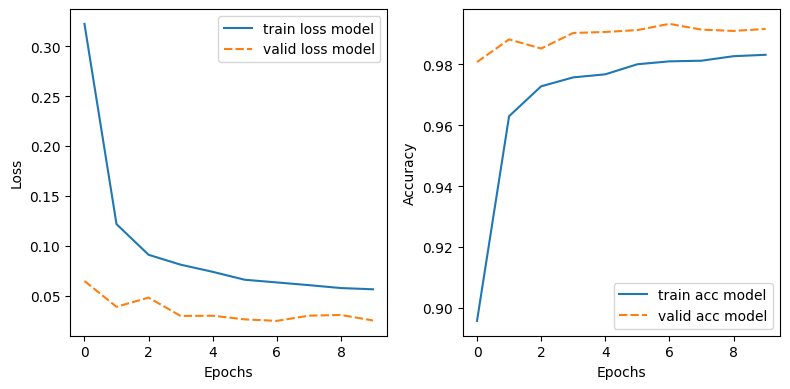

In [10]:
fig, axes = plt.subplots(1,2,figsize = (8,4))
sns.lineplot(data = losses_comparison, ax=axes[0])
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
sns.lineplot(data = accuracy_comparison, ax=axes[1])
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
plt.tight_layout()

**Checking performance on the test dataset**

In [11]:
model_cnn.load_state_dict(torch.load('tut1-model_cnn.pt'))

test_loss, test_acc = evaluate(model_cnn, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

C:\Users\GuillaumeClement\AppData\Local\Temp\ipykernel_17668\3408381743.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test Loss: 0.026 | Test Acc: 99.22%


**Checking the worst predictions**

C:\Users\GuillaumeClement\AppData\Local\Temp\ipykernel_17668\3408381743.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


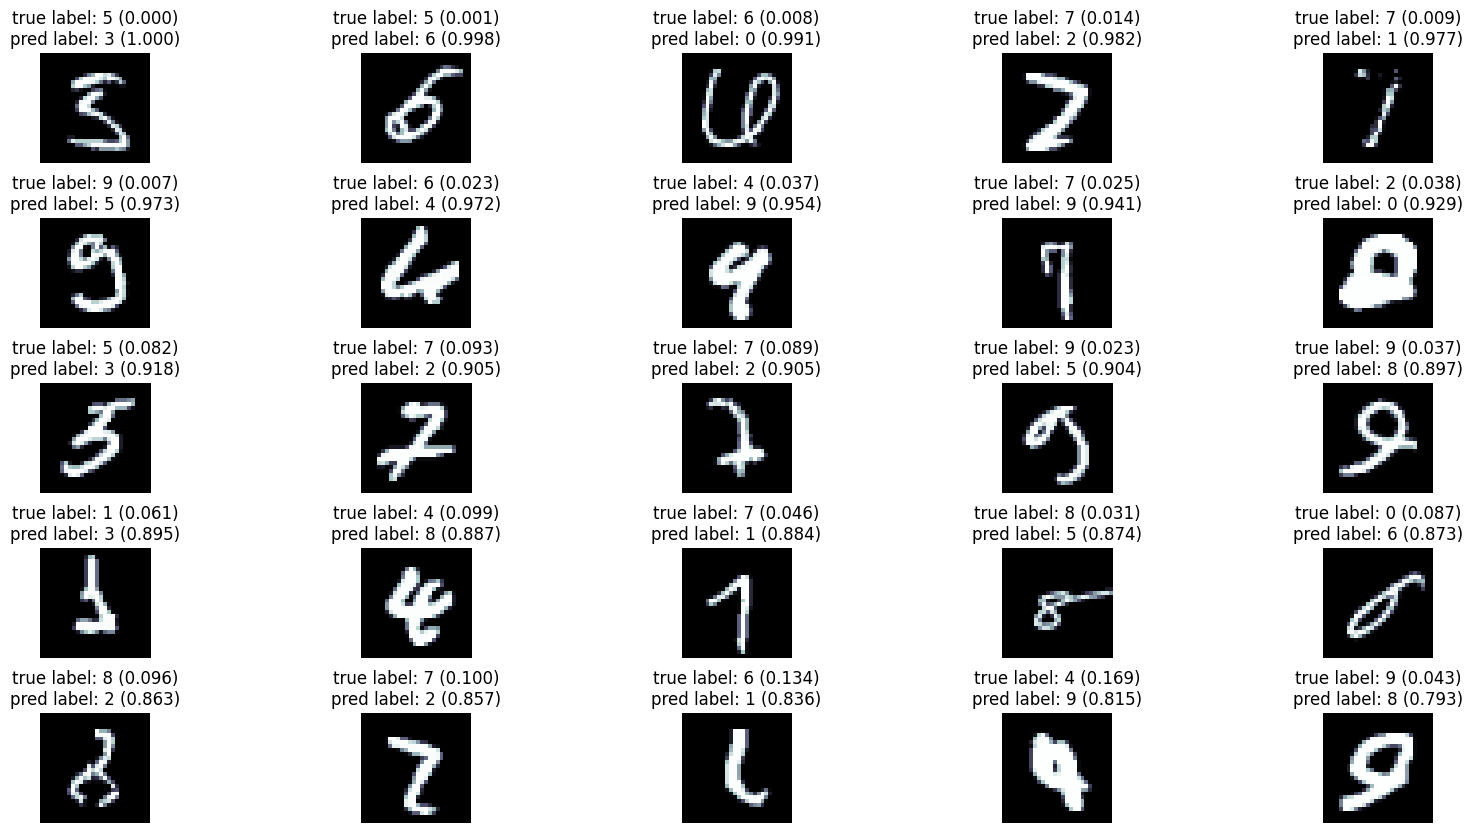

In [15]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace= 0.5)

images, labels, probs = get_predictions(model_cnn, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

corrects = torch.eq(labels, pred_labels)

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

## Results<br>

We have demonstrated a model that performs better than the MLPs, which is the expected result. Some refinement could be implemented on the different layers, the learning rate, the dropout, maybe in another update.